Importamos los paquetes necesarios

In [269]:
import cv2
import imutils
import numpy as np
#from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt
from PIL import Image

Cargamos nuestras imagenes

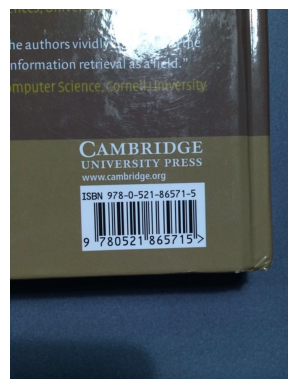

In [270]:
# img = cv2.imread('img/test/barcode_detector_test_025565.jpg', cv2.IMREAD_COLOR) #1º
# img = cv2.imread('img/test/Barcodes_val_010985.jpg', cv2.IMREAD_COLOR) #-45º
# img = cv2.imread('img/test/barcode_detector_train_025407.jpg', cv2.IMREAD_COLOR) #87º
# img = cv2.imread('img/test/thisisnotgood_val_016289.jpg', cv2.IMREAD_COLOR) #-23º
# img = cv2.imread('img/train/barcode_detector_test_025552.jpg', cv2.IMREAD_COLOR) #133º
# img = cv2.imread('images/barcode_01.jpg', cv2.IMREAD_COLOR) #47º
# img = cv2.imread('images/barcode_02.jpg', cv2.IMREAD_COLOR) #-23º
# img = cv2.imread('images/barcode_03.jpg', cv2.IMREAD_COLOR) #-45º
img = cv2.imread('images/barcode_04.jpg', cv2.IMREAD_COLOR) #87º
# img = cv2.imread('images/barcode_05.jpg', cv2.IMREAD_COLOR) #-133º
#img = cv2.imread('images/barcode_06.jpg', cv2.IMREAD_COLOR) #1º

plt.imshow(img)
plt.axis('off')
plt.show()

Un poco debug sucio

In [271]:
print(img.shape[1])

450


Definimos los factores de escala y redimensionamos la imagen

In [272]:
if 1600 > img.shape[1] > 1000:
    scale_x = 0.3
    scale_y = 0.3
elif img.shape[1] >= 1600:
    scale_x = 0.25
    scale_y = 0.25
else:
    scale_x = 1
    scale_y = 1

# Redimensionar la imagen utilizando factores de escala
img = cv2.resize(img, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_AREA)

Convertimos a escala de grises

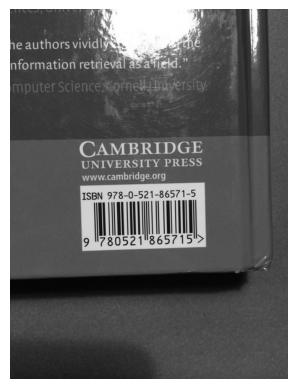

In [273]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

Calculamos la representacion de magnitud gradiente de Sharr de las imagenes en los dos ejes

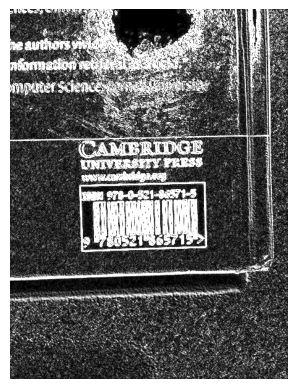

In [274]:
gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)

# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.imshow(gradient, cmap='gray')
plt.axis('off')
plt.show()

Rotacion fallida

In [275]:
# # Aplicar el detector de bordes Canny
# bordes = cv2.Canny(gray, 10, 240, L2gradient = True)

# # Mostrar los bordes detectados
# cv2.imshow('Bordes Canny', bordes)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # Transformada de Hough para detectar líneas
# lines = cv2.HoughLinesP(bordes, 1, np.pi/180, 40, minLineLength=30, maxLineGap=15)

# # Vamos a obter la orientación dominante de las líneas detectadas
# if lines is not None:
#     all_angles = []
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         dx = x2-x1
#         dy = y2-y1
#         angle = np.degrees(np.arctan2(dy, dx))
#         all_angles.append(angle)

#     dominant_angle = np.median(all_angles)

#     if -90 <= dominant_angle < 0:
#         rotacion = dominant_angle #-47º
#     elif 0 <= dominant_angle < 90:
#         rotacion = 90 - dominant_angle #47º
#     elif -180 < dominant_angle < -90:
#         rotacion = (180 + dominant_angle) + 90 #-133º
#     else:
#         rotacion = 90 - (180 - dominant_angle) #133º

# # Calculamos el centro de la imagen para la rotación
# alto, ancho = resized_image.shape[0:2]
# centro = (ancho // 2, alto // 2)
# angulo = rotacion
# escala = 1.0

# # Matriz de rotacion
# matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo, escala)

# # Aplicamos la rotacion
# imagen_rotada = cv2.warpAffine(resized_image, matriz_rotacion, (ancho, alto))

# # Mostrar la imagen con las líneas detectadas
# cv2.imshow('Deteccion de lineas', imagen_rotada)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

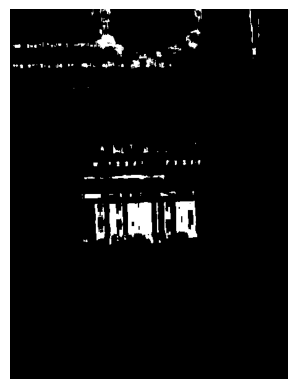

In [276]:
blurred = cv2.blur(gradient, (9, 9))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

Hacemos closing morfológico para unir las barras en una masa

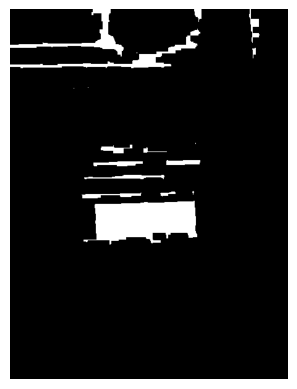

In [277]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Limpieza básica
closed = cv2.dilate(closed, None, iterations=4)
closed = cv2.erode(closed, None, iterations=4)

plt.imshow(closed, cmap='gray')
plt.axis('off')
plt.show()

Encontramos los contornos en la imagen procesada

In [278]:
cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

Hacemos un bounding box alrededor del contorno más grande

In [279]:
rect = cv2.minAreaRect(c)
print(rect)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = box.astype(int)

((209.79122924804688, 346.4031982421875), (66.35365295410156, 183.24429321289062), 88.31531524658203)


Vamos a comprobar que nos devuelve esto

In [280]:
print(box)

[[117 315]
 [300 310]
 [302 376]
 [119 382]]


Vamos a hacer más obvio y comprensible su output

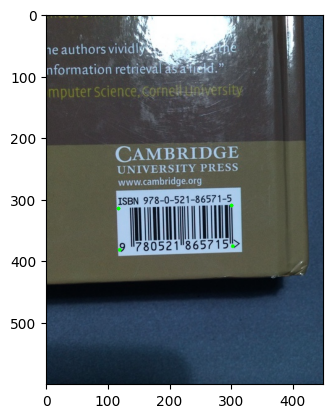

In [281]:
imagen_copia = img.copy()
for i in box:
    cv2.circle(img,(i[0],i[1]), 3, (0,255,0), -1)
imgplot = plt.imshow(img)
plt.show()

Vamos a guardar la rotacion, altura y anchura para poner la imagen derecha

In [282]:
angulo = rect[2]
alto, ancho = img.shape[0:2]
if angulo < -45:
    angulo = -(90 + angulo)
else:
    angulo = angulo - 90
matriz_rotacion = cv2.getRotationMatrix2D(rect[0], angulo, 1.0)
imagen_rotada = cv2.warpAffine(img, matriz_rotacion, (ancho, alto))
imagen_copia = cv2.warpAffine(imagen_copia, matriz_rotacion, (ancho, alto))

Rotamos el área del dibujo del código de barras

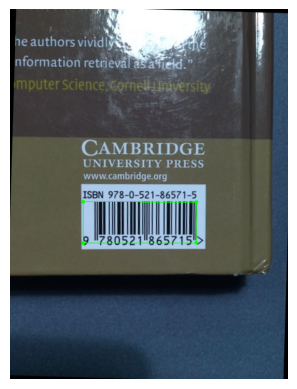

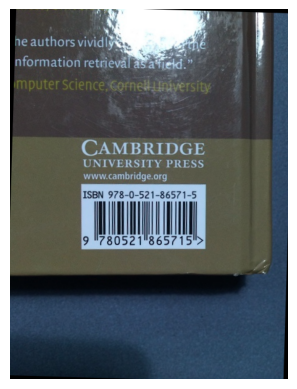

In [283]:
pts_rotados = cv2.transform(np.array([box]), matriz_rotacion)[0]

cv2.drawContours(imagen_rotada, [pts_rotados], -1, (0, 255, 0), 1)
imgplot = plt.imshow(imagen_rotada)
plt.axis('off')
plt.show()

plt.imshow(imagen_copia)
plt.axis('off')
plt.show()

Recortamos la imagen

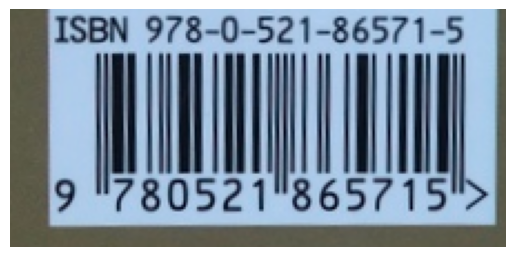

In [284]:
# Bounding box tras rotar
xs = pts_rotados[:, 0]
ys = pts_rotados[:, 1]

# Cogemos las coordenadas minimas y maximas ya que sino la imagen recortada sale mal
x_min, x_max = xs.min()-20, xs.max()+20
y_min, y_max = ys.min()-20, ys.max()+20

# Recortamos la imagen
imagen_recortada = imagen_copia[y_min:y_max, x_min:x_max]
imgplot = plt.imshow(imagen_recortada)
plt.axis('off')
plt.show()

Aquí debería implementar por mi mismo la interpretación del código de barras. Pero dejo una versión ya implementada de lo que debería ser

In [285]:
# def read_barcodes(img):
#     for d in decode(img):
#         img = cv2.rectangle(img, (d.rect.left, d.rect.top), (d.rect.left + d.rect.width, d.rect.top + d.rect.height), (0, 255, 0), 2)
#         img = cv2.putText(img, d.data.decode(), (d.rect.left, d.rect.top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
#     return img

# img = read_barcodes(imagen_recortada)
# imgplot = plt.imshow(img)
# plt.axis('off')
# plt.show()

Para que la imagen sea mas facil de procesar la binarizamos (solo blanco y negro)

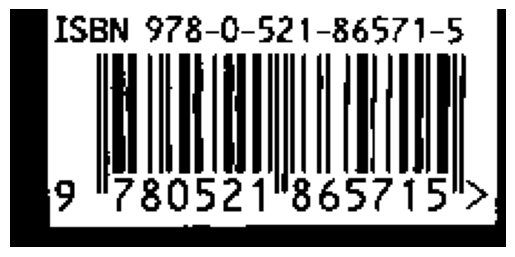

In [286]:
gray = cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (1, 1), 0) # Filtro Gaussiano para reducir el ruido
val, thresh_img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.axis("off")
plt.imshow(thresh_img, cmap = "gray")
plt.show()

Calculamos el centro de la imagen solo para asegurarnos de que el barcode se encuentra en el centro de la imagen.

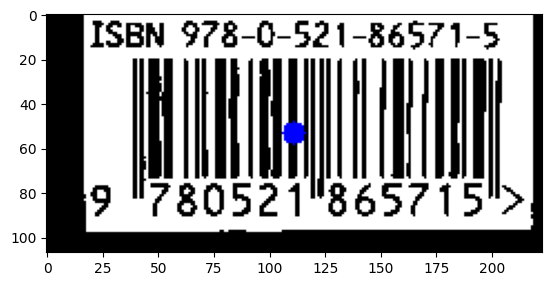

In [287]:
alto, ancho = thresh_img.shape[:2]

# Calcular las coordenadas del centro
centro_x = ancho // 2
centro_y = alto // 2

img_con_centro = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)

# Dibujar un círculo en el centro
cv2.circle(img_con_centro, (centro_x, centro_y), 5, (0, 0, 255), -1)
plt.imshow(img_con_centro)
plt.show()

Dibujamos una linea recta en medio de la imagen para obtener la señal rasterizada del codigo de barras.

Señal rasterizada:
[  0   0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255   0   0 255   0   0 255 255   0   0   0   0   0
 255 255   0   0   0   0 255 255 255 255 255   0   0 255 255 255   0   0
 255   0   0 255 255 255 255   0   0   0   0   0 255 255   0   0   0 255
 255 255 255 255   0   0 255 255 255   0   0   0   0 255 255   0   0   0
   0 255 255 255   0   0   0   0 255 255 255   0   0 255   0   0 255 255
   0   0 255   0   0 255 255 255   0   0 255 255 255 255 255   0   0 255
 255   0   0 255 255 255 255 255 255   0   0 255 255 255 255   0   0   0
   0   0 255   0   0 255 255 255 255 255   0   0 255 255 255 255   0   0
   0   0 255 255 255   0   0   0 255 255   0   0 255 255 255   0   0   0
   0   0 255 255   0   0 255   0   0 255 255 255 255]


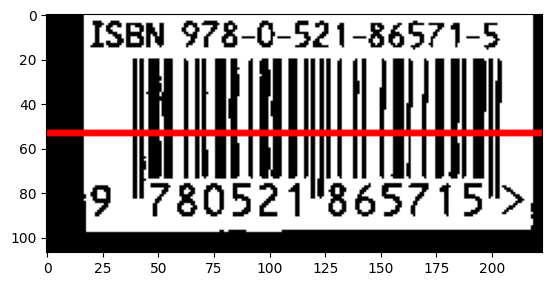

In [288]:
fila_central_idx = alto // 2
scan_line = thresh_img[fila_central_idx, 15:ancho-15] # Esto es debido a que le hemos añadido un ancho de 30 pixles

thresh_linea = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
cv2.line(thresh_linea, (0, fila_central_idx), (ancho, fila_central_idx), (255, 0, 0), 2)
plt.imshow(thresh_linea)

print("Señal rasterizada:")
print(scan_line)

Limpiamos la deteccion de barcode. Esto es por que a veces detecta los lados blancos (255) de la imagen antes del codigo negro (0).

In [289]:
scan_line = scan_line.tolist()

count = 0
for val in scan_line:
    if val == 255:
        count += 1
    else:
        break

scan_line = scan_line[count:]
count = 0

for val in scan_line[::-1]:
    if val == 255:
        count += 1
    else:
        break

scan_line = scan_line[:-count]
print(scan_line)

for i in range(len(scan_line)):
    if scan_line[i] == 255:
        scan_line[i] = 0
    else:
        scan_line[i] = 1

print(scan_line)

[0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 255, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 255, 255, 255, 0, 0, 255, 0, 0, 255, 255, 0, 0, 255, 0, 0, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 255, 255, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 255, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 

Vamos a calcular los anchos de las diferentes barras del código de barras. 

Basicamente, implemento un algoritmo de Run-Length Encoding (RLE) para transformar la señal rasterizada en vectores de anchura.

In [290]:
def calcular_anchos(lista_pixeles):
    lista_colores = []
    lista_anchos = []
    if not lista_pixeles:
        return anchos
    
    contador = 0
    valor_actual = lista_pixeles[0]

    for pixel in lista_pixeles:
        if pixel == valor_actual:
            contador += 1
        else:
            lista_colores.append(valor_actual)
            lista_anchos.append(contador)
            valor_actual = pixel
            contador = 1

    lista_anchos.append(contador)
    tupla = tuple(zip(lista_colores, lista_anchos))
    
    return tupla, lista_anchos

tupla_señal_rle,anchos_en_pixeles = calcular_anchos(scan_line)
print(f"Anchos en píxeles: {anchos_en_pixeles}")
print(f"Tupla señal RLE: {tupla_señal_rle}")

def limpiar_señal_rasterizada(tupla):
    contador = 0
    for i in range(len(tupla) - 1):
        color_zona, ancho_zona = tupla[i]
        color_barra, ancho_barra = tupla[i+1]
        
        if color_zona == 0 and color_barra == 1:
            if ancho_zona > ancho_barra*4:
                print(f"Inicio encontrado {i+1}")
                return i+1
    
    print("Inicio no encontrado")
    return 0

inicio_codigo = limpiar_señal_rasterizada(tupla_señal_rle)
anchos_en_pixeles = anchos_en_pixeles[inicio_codigo:]

print(f"Anchos en píxeles (después de limpiar): {anchos_en_pixeles}")

Anchos en píxeles: [2, 22, 2, 1, 2, 2, 5, 2, 4, 5, 2, 3, 2, 1, 2, 4, 5, 2, 3, 5, 2, 3, 4, 2, 4, 3, 4, 3, 2, 1, 2, 2, 2, 1, 2, 3, 2, 5, 2, 2, 2, 6, 2, 4, 5, 1, 2, 5, 2, 4, 4, 3, 3, 2, 2, 3, 5, 2, 2, 1, 2]
Tupla señal RLE: ((1, 2), (0, 22), (1, 2), (0, 1), (1, 2), (0, 2), (1, 5), (0, 2), (1, 4), (0, 5), (1, 2), (0, 3), (1, 2), (0, 1), (1, 2), (0, 4), (1, 5), (0, 2), (1, 3), (0, 5), (1, 2), (0, 3), (1, 4), (0, 2), (1, 4), (0, 3), (1, 4), (0, 3), (1, 2), (0, 1), (1, 2), (0, 2), (1, 2), (0, 1), (1, 2), (0, 3), (1, 2), (0, 5), (1, 2), (0, 2), (1, 2), (0, 6), (1, 2), (0, 4), (1, 5), (0, 1), (1, 2), (0, 5), (1, 2), (0, 4), (1, 4), (0, 3), (1, 3), (0, 2), (1, 2), (0, 3), (1, 5), (0, 2), (1, 2), (0, 1))
Inicio encontrado 2
Anchos en píxeles (después de limpiar): [2, 1, 2, 2, 5, 2, 4, 5, 2, 3, 2, 1, 2, 4, 5, 2, 3, 5, 2, 3, 4, 2, 4, 3, 4, 3, 2, 1, 2, 2, 2, 1, 2, 3, 2, 5, 2, 2, 2, 6, 2, 4, 5, 1, 2, 5, 2, 4, 4, 3, 3, 2, 2, 3, 5, 2, 2, 1, 2]


Ahora lo que queremos es detectar los códigos de barras en la imagen. Para ello voy a crear unos diccionarios de EAN-13 que es el estándar que se usa en los códigos de barras.

In [291]:
# === Diccionarios EAN-13 ===

# Paridades de los 6 primeros dígitos para obtener el primer dígito
# (L = 0, G = 1)
FIRST_DIGIT_PARITY = {
    "LLLLLL": 0,
    "LLGLGG": 1,
    "LLGGLG": 2,
    "LLGGGL": 3,
    "LGLLGG": 4,
    "LGGLLG": 5,
    "LGGGLL": 6,
    "LGLGLG": 7,
    "LGLGGL": 8,
    "LGGLGL": 9,
}

L_CODES_MAP = {
    (3, 2, 1, 1): 0,
    (2, 2, 2, 1): 1,
    (2, 1, 2, 2): 2,
    (1, 4, 1, 1): 3,
    (1, 1, 3, 2): 4,
    (1, 2, 3, 1): 5,
    (1, 1, 1, 4): 6,
    (1, 3, 1, 2): 7,
    (1, 2, 1, 3): 8,
    (3, 1, 1, 2): 9,
}

G_CODES_MAP = {
    (1, 1, 2, 3): 0,
    (1, 2, 2, 2): 1,
    (2, 2, 1, 2): 2,
    (1, 1, 4, 1): 3,
    (2, 3, 1, 1): 4,
    (1, 3, 2, 1): 5,
    (4, 1, 1, 1): 6,
    (2, 1, 3, 1): 7,
    (3, 1, 2, 1): 8,
    (2, 1, 1, 3): 9,
}

Es importante tener en cuenta que el EAN-13 funciona con unidades relativas llamadas módulos.

- Barra fina = 1 módulo.
- Barra ancha = 2, 3 o 4 módulos.

Entonces, ahora cómo sabemos cuánto mide 1 módulo en las imagenes? Implementando una normalización local y adaptativa. En lugar de calcular un valor global, recalculamos el tamaño del módulo para cada dígito individualmente, basándonos en la estructura rígida del estándar EAN-13. Esto hace que el calculo sea robusto a codigos curvados.

Algoritmo:

1. Sincronización: Recorremos la señal rasterizada (lista de anchos en píxeles) secuencialmente.
2. Cálculo Local:
    - Para los Dígitos: Tomamos grupos de 4 elementos (barra-espacio-barra-espacio) y dividimos su ancho total en píxeles entre 7 (ancho estándar en módulos).
    - Para el Guardia Central: Tomamos 5 elementos y dividimos entre 5.
    - Para los Guardias Laterales: Tomamos 3 elementos y dividimos entre 3.
3. Discretización: Convertimos cada ancho de píxel a su valor entero en módulos ($1, 2, 3, 4$) usando esa referencia local.

También dividimos el ancho en mitades para no tener en cuenta los guard bars.


In [292]:
def normalizador(anchos_modulos, chunk, modulo_local):
    for p in chunk:
        m = round(p / modulo_local)
        anchos_modulos.append(max(1, int(m)))
    return anchos_modulos

def normalizador_laterales(anchos_pixeles, indice, anchos_modulos):
    for _ in range(6):
        grupo = anchos_pixeles[indice : indice + 4]
        modulo_local = sum(grupo) / 7.0
        normalizador(anchos_modulos, grupo, modulo_local)
        indice += 4
    return anchos_modulos, indice 

def normalizar_señal_adaptativa(anchos_pixeles):
    # Validación
    if len(anchos_pixeles) < 59:
        print("Error: Faltan datos en la señal rasterizada.")
        return []

    anchos_modulos = []
    indice = 3

    # Lado izquierdo
    anchos_modulos, indice = normalizador_laterales(anchos_pixeles, indice, anchos_modulos)

    # Guard bars centrales
    grupo = anchos_pixeles[indice : indice + 5]
    modulo_local = sum(grupo) / 5.0
    anchos_modulos = normalizador(anchos_modulos, grupo, modulo_local)
    indice += 5

    # Lado derecho
    anchos_modulos, indice = normalizador_laterales(anchos_pixeles, indice, anchos_modulos)
    return anchos_modulos

anchos_modulos = normalizar_señal_adaptativa(anchos_en_pixeles)
print(anchos_modulos)

[1, 3, 1, 2, 3, 1, 2, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 4, 1, 2, 3, 1, 1, 3, 1, 2, 2, 2, 2, 1, 1, 2, 3, 1]


In [293]:
# Dividimos en mitades
fin_izq = 24
inicio_der = fin_izq + 5

primera_mitad = anchos_modulos[:fin_izq]
segunda_mitad = anchos_modulos[inicio_der:]

print(f"Primera mitad ({len(primera_mitad)} elementos): {primera_mitad}")
print(f"Segunda mitad ({len(segunda_mitad)} elementos): {segunda_mitad}")

# Verificación de seguridad
if len(primera_mitad) != 24 or len(segunda_mitad) != 24:
    print("Revisar la detección de bordes.")

Primera mitad (24 elementos): [1, 3, 1, 2, 3, 1, 2, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2, 1]
Segunda mitad (24 elementos): [1, 2, 1, 3, 1, 1, 1, 4, 1, 2, 3, 1, 1, 3, 1, 2, 2, 2, 2, 1, 1, 2, 3, 1]


Vamos a decodificar nuestros primeros dígitos. Tenemos que tener en cuenta que al poder tener codigos EAN-13 debemos calcular la paridad del primer digito.

In [294]:
def decodificar(mitad, que_mitad):

    decoded_digits = []
    parity_pattern = ""

    for i in range(0, len(mitad), 4):
        chunk = tuple(mitad[i : i+4])

        while sum(chunk) > 7:
            print(f"Corrigiendo chunk: {chunk} (Suma: {sum(chunk)})")
            modificar_mod = max(chunk) - 1
            lista = list(chunk)
            lista[lista.index(max(chunk))] = modificar_mod
            chunk = tuple(lista)
            print(f"Chunk corregido: {chunk} (Suma: {sum(chunk)})")
            
        while sum(chunk) < 7:
            print(f"Corrigiendo chunk: {chunk} (Suma: {sum(chunk)})")
            modificar_mod = min(chunk) + 1
            lista = list(chunk)
            lista[lista.index(min(chunk))] = modificar_mod
            chunk = tuple(lista)
            print(f"Chunk corregido: {chunk} (Suma: {sum(chunk)})")
        
        digit = None
        code_type = None

        if chunk in L_CODES_MAP:
            digit = L_CODES_MAP[chunk]
            code_type = "L"
        elif chunk in G_CODES_MAP:
            digit = G_CODES_MAP[chunk]
            code_type = "G"
   
        if digit is not None:
            decoded_digits.append(digit)
            if que_mitad == 0:
                parity_pattern += code_type

    if parity_pattern in FIRST_DIGIT_PARITY and que_mitad == 0:
        decoded_digits.insert(0, FIRST_DIGIT_PARITY[parity_pattern])
    
    return decoded_digits

decoded_digits = decodificar(primera_mitad, 0)
decoded_digits += (decodificar(segunda_mitad, 1))
print(f"El codigo decodificado es: {decoded_digits}")

El codigo decodificado es: [9, 7, 8, 0, 5, 2, 1, 8, 6, 5, 7, 1, 5]


Como funcionalidad extra calcularemos tambien el origen (pais) del producto.

In [295]:
GS1_PREFIXES = {
    '00': 'EE.UU / Canadá', '01': 'EE.UU / Canadá', 
    '02': 'Uso restringido', '03': 'EE.UU', '04': 'EE.UU',
    '05': 'EE.UU', '06': 'EE.UU', '07': 'EE.UU', '08': 'EE.UU',
    '09': 'EE.UU', '10': 'EE.UU', '11': 'EE.UU', '12': 'EE.UU', '13': 'EE.UU',
    '30': 'Francia', '31': 'Francia', '32': 'Francia', '33': 'Francia',
    '34': 'Francia', '35': 'Francia', '36': 'Francia', '37': 'Francia',
    '40': 'Alemania', '41': 'Alemania', '42': 'Alemania', '43': 'Alemania', '44': 'Alemania',
    '45': 'Japón', '49': 'Japón',
    '50': 'Reino Unido',
    '520': 'Grecia',
    '528': 'Líbano',
    '529': 'Chipre',
    '531': 'Macedonia',
    '535': 'Malta',
    '539': 'Irlanda',
    '54': 'Bélgica / Luxemburgo',
    '560': 'Portugal',
    '569': 'Islandia',
    '57': 'Dinamarca',
    '590': 'Polonia',
    '594': 'Rumanía',
    '599': 'Hungría',
    '600': 'Sudáfrica', '601': 'Sudáfrica',
    '609': 'Mauricio',
    '611': 'Marruecos',
    '613': 'Argelia',
    '619': 'Túnez',
    '64': 'Finlandia',
    '690': 'China', '691': 'China', '692': 'China', '693': 'China', '694': 'China', '695': 'China',
    '70': 'Noruega',
    '729': 'Israel',
    '73': 'Suecia',
    '740': 'Guatemala', '741': 'El Salvador', '742': 'Honduras', 
    '743': 'Nicaragua', '744': 'Costa Rica', '745': 'Panamá',
    '750': 'México',
    '759': 'Venezuela',
    '76': 'Suiza',
    '770': 'Colombia',
    '773': 'Uruguay',
    '775': 'Perú',
    '777': 'Bolivia',
    '779': 'Argentina',
    '780': 'Chile',
    '784': 'Paraguay',
    '786': 'Ecuador',
    '789': 'Brasil', '790': 'Brasil',
    '80': 'Italia', '81': 'Italia', '82': 'Italia', '83': 'Italia',
    '84': 'España',
    '850': 'Cuba',
    '858': 'Eslovaquia',
    '859': 'República Checa',
    '860': 'Serbia',
    '868': 'Turquía', '869': 'Turquía',
    '87': 'Países Bajos (Holanda)',
    '880': 'Corea del Sur',
    '885': 'Tailandia',
    '888': 'Singapur',
    '890': 'India',
    '893': 'Vietnam',
    '90': 'Austria', '91': 'Austria',
    '93': 'Australia',
    '94': 'Nueva Zelanda',
    '955': 'Malasia',
    '958': 'Macao',
    '977': 'Publicaciones (ISSN)',
    '978': 'Libros (ISBN)',
    '979': 'Libros / Música'
}

def detectar_pais(codigo_ean):

    # Asegurarnos de que es un string
    if isinstance(codigo_ean, list):
        codigo_str = "".join(map(str, codigo_ean))
    else:
        codigo_str = str(codigo_ean)

    prefijo_3 = codigo_str[:3]
    if prefijo_3 in GS1_PREFIXES:
        return GS1_PREFIXES[prefijo_3]
    
    prefijo_2 = codigo_str[:2]
    if prefijo_2 in GS1_PREFIXES:
        return GS1_PREFIXES[prefijo_2]
    
    return "Desconocido"

decoded_digits = "".join(map(str, decoded_digits))
print(decoded_digits)
detectar_pais(decoded_digits)

9780521865715


'Libros (ISBN)'